# Predict Stock Market Trend Using Macro Economical Factors

### Importing libraries

In [146]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['axes.grid'] = False
sns.set(style="whitegrid", font_scale=1.5)

### Helper Functions

In [147]:
def set_date_index(dataframe, col = "DATE"):
    dataframe[col] = pd.to_datetime(dataframe[col])

In [148]:
def set_to_numeric(dataframe, col):
    dataframe[col] = pd.to_numeric(dataframe[col])

In [149]:
def merge_datasets(features, target):
    for feature in features:
        target = target.merge(feature, how='left', on='DATE')
    return target

### Importing datasets

In [150]:
df_GDP = pd.read_csv('./dataset/GDPC1.csv')
df_UNEMP = pd.read_csv('./dataset/UNEMP.csv')
df_FEDINTRate = pd.read_csv('./dataset/FedFundEffectiveRate.csv')
df_INF = pd.read_csv('./dataset/INFLATION.csv')
df_AAABondYield = pd.read_csv('./dataset/MoodyAaaCorporateBondYield.csv')
df_FEDDebt = pd.read_csv('./dataset/FEDDEBT.csv')
df_3MTBills = pd.read_csv('./dataset/3MTBill.csv')
df_SP500 = pd.read_csv('./dataset/SP500_1.csv')

In [151]:
def load_features():
    global GDP
    GDP = 'GDP'
    global Unemployment_Rate
    Unemployment_Rate = 'UNEMP'
    global FEDInterestRate
    FEDInterestRate = 'FED_Interest_Rate'
    global Inflation
    Inflation = 'INF'
    global Govt_Debt
    Govt_Debt = 'Govt_Debt'
    global Treasury_Bills
    Treasury_Bills = '3M_TBILLS'
    global BondYields
    BondYields = 'BondYields'
    
    df_GDP = pd.read_csv('./dataset/GDPC1.csv')
    df_UNEMP = pd.read_csv('./dataset/UNEMP.csv')
    df_FEDINTRate = pd.read_csv('./dataset/FedFundEffectiveRate.csv')
    df_INF = pd.read_csv('./dataset/INFLATION.csv')
    df_AAABondYield = pd.read_csv('./dataset/MoodyAaaCorporateBondYield.csv')
    df_FEDDebt = pd.read_csv('./dataset/FEDDEBT.csv')
    df_3MTBills = pd.read_csv('./dataset/3MTBill.csv')
    return { GDP : df_GDP, 
            Unemployment_Rate : df_UNEMP, 
            FEDInterestRate : df_FEDINTRate,
            Inflation : df_INF,
            Govt_Debt: df_FEDDebt,
            Treasury_Bills : df_3MTBills,
            BondYields: df_AAABondYield
           }

In [152]:
def prepare_features(features):
    features = [features[GDP], 
                features[Unemployment_Rate], 
                features[Inflation], 
                features[Govt_Debt],
                features[Treasury_Bills], 
                features[BondYields],
                features[Govt_Debt],
                features[Govt_Debt]
                df_AAABondYield, df_FEDDebt, df_3MTBills]
    for df in features:
        set_date_index(df)

SyntaxError: invalid syntax (72656430.py, line 10)

In [153]:
def load_SP500():
    global SP500
    SP500 = 'SP500'
    df_SP500 = pd.read_csv('./dataset/SP500_1.csv')
    df_SP500.rename(columns={'Date' : 'DATE', ' Close': 'Close'}, inplace=True)
    df_SP500.drop(columns=[' Open', ' High', ' Low'], inplace=True)
    set_date_index(df_SP500)
    return df_SP500

In [154]:
features = load_features()

In [155]:
sp_500 = load_SP500()

### Data Pre-Processing 

In [156]:
df_SP500.describe()

,Open,High,Low,Close
count,5930.000000,5930.000000,5930.000000,5930.000000
mean,1928.514442,1940.043705,1916.199410,1928.831295
std,1016.264475,1021.531037,1010.712063,1016.514364
min,675.130000,695.270000,666.790000,676.530000
25%,1188.287500,1195.407500,1180.982500,1188.820000
50%,1447.055000,1456.755000,1436.335000,1447.135000
75%,2469.005000,2477.875000,2460.207500,2471.987500
max,4804.510000,4818.620000,4780.040000,4796.560000


In [157]:
df_SP500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5930 entries, 0 to 5929
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5930 non-null   object 
 1    Open   5930 non-null   float64
 2    High   5930 non-null   float64
 3    Low    5930 non-null   float64
 4    Close  5930 non-null   float64
dtypes: float64(4), object(1)
memory usage: 231.8+ KB


In [158]:
df_SP500.rename(columns={'Date' : 'DATE', ' Close': 'Close', ' Open': 'Open', ' High': 'High', ' Low': 'Low'}, inplace=True)
#df_SP500.drop(columns=[' Open', ' High', ' Low'], inplace=True)
set_date_index(df_SP500)

###### set date index

In [159]:
features = [df_GDP, df_UNEMP, df_FEDINTRate, df_INF, df_AAABondYield, df_FEDDebt, df_3MTBills]
#setting date column as index index
for df in features:
    set_date_index(df)

In [160]:
#df_AAABondYield
df_AAABondYield['DAAA'].replace(".", method='ffill', inplace=True )
df_AAABondYield.rename(columns={'DAAA' : 'BOND_YIELD'}, inplace=True)
set_to_numeric(df_AAABondYield, 'BOND_YIELD')

In [161]:
#df_INF
df_INF['T10YIE'].replace(".", method='ffill', inplace=True )
df_INF.rename(columns={'T10YIE' : 'INF'}, inplace=True)
set_to_numeric(df_INF, 'INF')

In [162]:
#df_3MonthTBills
df_3MTBills['DTB3'].replace(".", method='ffill', inplace=True )
df_3MTBills.rename(columns={'DTB3' : '3M_TBILLS'}, inplace=True)
set_to_numeric(df_3MTBills, '3M_TBILLS')

In [163]:
#df_gdp
df_GDP.rename(columns={'GDPC1' : 'GDP'}, inplace = True)
set_to_numeric(df_GDP, 'GDP')

In [164]:
#df_unemployment
df_UNEMP.rename(columns={'UNRATE' : 'UNEMP_RATE'}, inplace=True)
set_to_numeric(df_UNEMP, 'UNEMP_RATE')

In [165]:
#df_fedInterestRate
df_FEDINTRate.rename(columns={'DFF' : 'INT_RATE'}, inplace=True)
set_to_numeric(df_FEDINTRate, 'INT_RATE')

In [166]:
#df_fedDebt
df_FEDDebt.rename(columns={'GFDEBTN' : 'GOVT_DEBT'}, inplace=True)
set_to_numeric(df_FEDDebt, 'GOVT_DEBT')

# EDA - Exploring Data

### Merge Datasets

In [167]:
dataset_input = merge_datasets(features, df_SP500)

In [168]:
dataset_input.fillna(method='ffill', inplace=True)

In [169]:
dataset_input.isna().sum()

DATE            0
Open            0
High            0
Low             0
Close           0
GDP           269
UNEMP_RATE     39
INT_RATE        4
INF             3
BOND_YIELD      4
GOVT_DEBT     269
3M_TBILLS       4
dtype: int64

In [170]:
dataset_input.dropna(inplace=True)

In [171]:
dataset_input.describe()

,Open,High,Low,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
count,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5.661000e+03,5661.000000
mean,1828.109670,1838.851046,1816.457460,1828.303310,16390.813809,6.062939,1.616169,2.008467,4.757009,1.522037e+07,1.481203
std,925.963942,930.193428,921.081287,925.935974,1961.268688,2.203219,1.875895,0.414319,1.333459,7.362522e+06,1.730611
min,675.130000,695.270000,666.790000,676.530000,13284.881000,3.500000,0.040000,0.040000,2.010000,5.943439e+06,-0.050000
25%,1178.860000,1186.620000,1170.850000,1178.840000,15161.772000,4.500000,0.130000,1.640000,3.780000,9.229172e+06,0.090000
50%,1418.130000,1427.720000,1409.090000,1418.260000,15876.839000,5.400000,0.990000,2.060000,4.750000,1.479034e+07,0.920000
75%,2186.080000,2188.450000,2180.380000,2186.900000,17724.489000,7.200000,2.310000,2.340000,5.580000,2.197410e+07,2.180000
max,4804.510000,4818.620000,4780.040000,4796.560000,20054.663000,14.700000,7.030000,3.020000,8.120000,3.092891e+07,6.240000


In [172]:
dataset_input

,DATE,Open,High,Low,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
269,2022-07-01,3781.08,3829.82,3752.10,3825.33,20054.663,3.5,1.58,2.34,4.26,30928912.0,1.66
270,2022-06-30,3785.99,3818.99,3738.67,3785.38,20054.663,3.5,1.58,2.33,4.19,30928912.0,1.66
271,2022-06-29,3825.09,3836.50,3799.02,3818.83,20054.663,3.5,1.58,2.36,4.21,30928912.0,1.73
272,2022-06-28,3913.00,3945.86,3820.14,3821.55,20054.663,3.5,1.58,2.48,4.30,30928912.0,1.75
273,2022-06-27,3920.76,3927.72,3889.66,3900.11,20054.663,3.5,1.58,2.55,4.29,30928912.0,1.75
...,...,...,...,...,...,...,...,...,...,...,...,...
5925,2000-01-07,1441.47,1441.47,1400.53,1441.47,13284.881,4.1,5.61,1.64,7.69,5943439.0,5.22
5926,2000-01-06,1403.45,1411.90,1392.02,1403.45,13284.881,4.1,5.54,1.64,7.72,5943439.0,5.25
5927,2000-01-05,1402.11,1413.27,1377.68,1402.11,13284.881,4.1,5.41,1.64,7.78,5943439.0,5.28
5928,2000-01-04,1399.42,1455.22,1397.43,1399.42,13284.881,4.1,5.38,1.64,7.69,5943439.0,5.27


In [173]:
dataset_input.isna().sum()

DATE          0
Open          0
High          0
Low           0
Close         0
GDP           0
UNEMP_RATE    0
INT_RATE      0
INF           0
BOND_YIELD    0
GOVT_DEBT     0
3M_TBILLS     0
dtype: int64

In [174]:
dataset_input.describe()

,Open,High,Low,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
count,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5.661000e+03,5661.000000
mean,1828.109670,1838.851046,1816.457460,1828.303310,16390.813809,6.062939,1.616169,2.008467,4.757009,1.522037e+07,1.481203
std,925.963942,930.193428,921.081287,925.935974,1961.268688,2.203219,1.875895,0.414319,1.333459,7.362522e+06,1.730611
min,675.130000,695.270000,666.790000,676.530000,13284.881000,3.500000,0.040000,0.040000,2.010000,5.943439e+06,-0.050000
25%,1178.860000,1186.620000,1170.850000,1178.840000,15161.772000,4.500000,0.130000,1.640000,3.780000,9.229172e+06,0.090000
50%,1418.130000,1427.720000,1409.090000,1418.260000,15876.839000,5.400000,0.990000,2.060000,4.750000,1.479034e+07,0.920000
75%,2186.080000,2188.450000,2180.380000,2186.900000,17724.489000,7.200000,2.310000,2.340000,5.580000,2.197410e+07,2.180000
max,4804.510000,4818.620000,4780.040000,4796.560000,20054.663000,14.700000,7.030000,3.020000,8.120000,3.092891e+07,6.240000


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
      dtype=object)

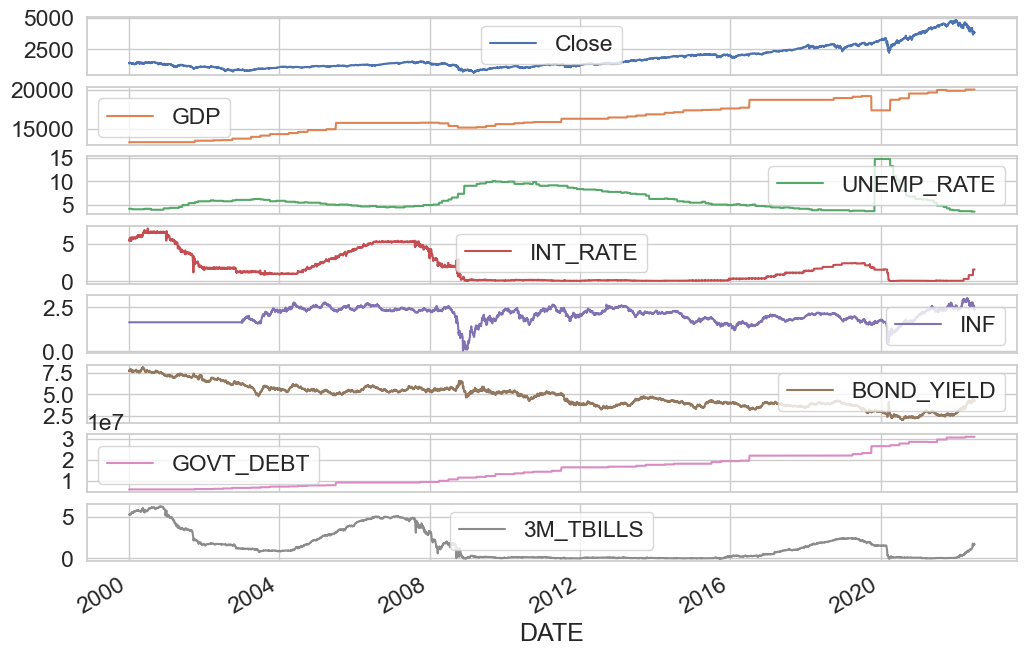

In [175]:
dataset_input.set_index('DATE')[['Close','GDP','UNEMP_RATE','INT_RATE', 'INF', 'BOND_YIELD', 'GOVT_DEBT', '3M_TBILLS']].plot(subplots=True)

In [176]:
from sklearn.preprocessing import MinMaxScaler

In [177]:
scaler = MinMaxScaler()

In [178]:
data_scaled = scaler.fit_transform(dataset_input.loc[:, ~dataset_input.columns.isin(['DATE'])])

In [179]:
data_scaled

array([[0.75215892, 0.76019499, 0.75009056, ..., 0.36824877, 1.        ,
        0.2718601 ],
       [0.75334796, 0.75756848, 0.7468255 , ..., 0.35679214, 1.        ,
        0.2718601 ],
       [0.76281669, 0.76181503, 0.7614976 , ..., 0.36006547, 1.        ,
        0.28298887],
       ...,
       [0.17605064, 0.17413026, 0.17282927, ..., 0.94435352, 0.        ,
        0.84737679],
       [0.17539921, 0.18430402, 0.17763083, ..., 0.92962357, 0.        ,
        0.84578696],
       [0.18891214, 0.18982866, 0.1875816 , ..., 0.93944354, 0.        ,
        0.84578696]])

In [180]:
features = data_scaled
target = data_scaled[:,0]

In [181]:
features

array([[0.75215892, 0.76019499, 0.75009056, ..., 0.36824877, 1.        ,
        0.2718601 ],
       [0.75334796, 0.75756848, 0.7468255 , ..., 0.35679214, 1.        ,
        0.2718601 ],
       [0.76281669, 0.76181503, 0.7614976 , ..., 0.36006547, 1.        ,
        0.28298887],
       ...,
       [0.17605064, 0.17413026, 0.17282927, ..., 0.94435352, 0.        ,
        0.84737679],
       [0.17539921, 0.18430402, 0.17763083, ..., 0.92962357, 0.        ,
        0.84578696],
       [0.18891214, 0.18982866, 0.1875816 , ..., 0.93944354, 0.        ,
        0.84578696]])

In [182]:
target

array([0.75215892, 0.75334796, 0.76281669, ..., 0.17605064, 0.17539921,
       0.18891214])

In [183]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

In [184]:
x_train.shape

(4528, 11)

In [185]:
y_train.shape

(4528,)

In [186]:
x_test.shape

(1133, 11)

In [187]:
y_test.shape

(1133,)

In [188]:
win_length = 25
batch_size=40
num_of_features = 11

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, batch_size=batch_size, stride=1)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, batch_size=batch_size, stride=1)

In [191]:
train_generator[0]

(array([[[0.75215892, 0.76019499, 0.75009056, ..., 0.36824877,
          1.        , 0.2718601 ],
         [0.75334796, 0.75756848, 0.7468255 , ..., 0.35679214,
          1.        , 0.2718601 ],
         [0.76281669, 0.76181503, 0.7614976 , ..., 0.36006547,
          1.        , 0.28298887],
         ...,
         [0.84176317, 0.84229328, 0.83585729, ..., 0.32569558,
          1.        , 0.18759936],
         [0.82388155, 0.83990445, 0.82918374, ..., 0.31751227,
          1.        , 0.17647059],
         [0.80144477, 0.8196903 , 0.80661521, ..., 0.32242226,
          1.        , 0.17647059]],
 
        [[0.75334796, 0.75756848, 0.7468255 , ..., 0.35679214,
          1.        , 0.2718601 ],
         [0.76281669, 0.76181503, 0.7614976 , ..., 0.36006547,
          1.        , 0.28298887],
         [0.7841056 , 0.78833715, 0.76663223, ..., 0.37479542,
          1.        , 0.28616852],
         ...,
         [0.82388155, 0.83990445, 0.82918374, ..., 0.31751227,
          1.        , 0.

In [192]:
train_generator[1]

(array([[[0.84904998, 0.87608134, 0.84656172, ..., 0.33878887,
          1.        , 0.14785374],
         [0.8438676 , 0.84999576, 0.84611682, ..., 0.34369885,
          1.        , 0.15103339],
         [0.83680359, 0.84264979, 0.82555643, ..., 0.35515548,
          1.        , 0.15103339],
         ...,
         [0.93602187, 0.93453866, 0.93375798, ..., 0.21440262,
          0.98557842, 0.09062003],
         [0.95023708, 0.94772454, 0.93931076, ..., 0.22422259,
          0.98557842, 0.08903021],
         [0.95633485, 0.95371482, 0.95168784, ..., 0.22749591,
          0.98557842, 0.09538951]],
 
        [[0.8438676 , 0.84999576, 0.84611682, ..., 0.34369885,
          1.        , 0.15103339],
         [0.83680359, 0.84264979, 0.82555643, ..., 0.35515548,
          1.        , 0.15103339],
         [0.86662405, 0.86687038, 0.84057376, ..., 0.32733224,
          1.        , 0.13990461],
         ...,
         [0.95023708, 0.94772454, 0.93931076, ..., 0.22422259,
          0.98557842, 0.

In [257]:
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_of_features), return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
#model.add(tf.keras.layers.LSTM(128,return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.LSTM(64, return_sequences=False))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Dense(1))

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(win_length, num_of_features), return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=False))
model.add(Dense(1))

In [258]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 25, 64)            19456     
                                                                 
 lstm_25 (LSTM)              (None, 4)                 1104      
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 20,565
Trainable params: 20,565
Non-trainable params: 0
_________________________________________________________________


In [259]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')

In [260]:
model.compile(loss=tf.losses.MeanSquaredError(), 
             optimizer=tf.optimizers.Adam(),
             metrics=[tf.metrics.MeanAbsoluteError()])

In [261]:
history = model.fit(train_generator, epochs=100, batch_size=batch_size, validation_data=test_generator, 
                    shuffle=False,
#                   callbacks=[early_stopping])
                    callbacks=[])

Epoch 1/100
113/113 [==============================] - 3s 13ms/step - loss: 0.0250 - mean_absolute_error: 0.0732 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314
Epoch 2/100
113/113 [==============================] - 1s 11ms/step - loss: 0.0112 - mean_absolute_error: 0.0557 - val_loss: 8.6340e-04 - val_mean_absolute_error: 0.0233
Epoch 3/100
113/113 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_absolute_error: 0.0443 - val_loss: 0.0010 - val_mean_absolute_error: 0.0272
Epoch 4/100
113/113 [==============================] - 1s 11ms/step - loss: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 8.5285e-04 - val_mean_absolute_error: 0.0252
Epoch 5/100
113/113 [==============================] - 1s 11ms/step - loss: 0.0015 - mean_absolute_error: 0.0314 - val_loss: 3.8658e-04 - val_mean_absolute_error: 0.0164
Epoch 6/100
113/113 [==============================] - 1s 11ms/step - loss: 0.0017 - mean_absolute_error: 0.0328 - val_loss: 4.2159e-04 - val_mean_absolute_er

113/113 [==============================] - 1s 11ms/step - loss: 6.5207e-04 - mean_absolute_error: 0.0203 - val_loss: 8.0869e-04 - val_mean_absolute_error: 0.0235
Epoch 49/100
113/113 [==============================] - 1s 12ms/step - loss: 4.8391e-04 - mean_absolute_error: 0.0170 - val_loss: 5.2190e-04 - val_mean_absolute_error: 0.0187
Epoch 50/100
113/113 [==============================] - 1s 12ms/step - loss: 3.3279e-04 - mean_absolute_error: 0.0140 - val_loss: 6.3858e-04 - val_mean_absolute_error: 0.0205
Epoch 51/100
113/113 [==============================] - 1s 12ms/step - loss: 4.8362e-04 - mean_absolute_error: 0.0172 - val_loss: 6.7123e-04 - val_mean_absolute_error: 0.0219
Epoch 52/100
113/113 [==============================] - 1s 11ms/step - loss: 8.9005e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0011 - val_mean_absolute_error: 0.0286
Epoch 53/100
113/113 [==============================] - 1s 12ms/step - loss: 8.5112e-04 - mean_absolute_error: 0.0221 - val_loss: 9.6336e-04 -

113/113 [==============================] - 1s 11ms/step - loss: 2.7676e-04 - mean_absolute_error: 0.0119 - val_loss: 2.8708e-04 - val_mean_absolute_error: 0.0149
Epoch 96/100
113/113 [==============================] - 1s 11ms/step - loss: 1.8745e-04 - mean_absolute_error: 0.0096 - val_loss: 1.4133e-04 - val_mean_absolute_error: 0.0095
Epoch 97/100
113/113 [==============================] - 1s 11ms/step - loss: 1.8368e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1659e-04 - val_mean_absolute_error: 0.0087
Epoch 98/100
113/113 [==============================] - 1s 11ms/step - loss: 1.2777e-04 - mean_absolute_error: 0.0080 - val_loss: 1.9774e-04 - val_mean_absolute_error: 0.0118
Epoch 99/100
113/113 [==============================] - 1s 11ms/step - loss: 2.2757e-04 - mean_absolute_error: 0.0107 - val_loss: 1.6917e-04 - val_mean_absolute_error: 0.0111
Epoch 100/100
113/113 [==============================] - 1s 11ms/step - loss: 3.3841e-04 - mean_absolute_error: 0.0126 - val_loss: 2.3362e

In [262]:
len(test_generator)

28

In [263]:
model.evaluate_generator(test_generator, verbose=1)

28/28 [==============================] - 0s 5ms/step - loss: 2.3362e-04 - mean_absolute_error: 0.0133


[0.00023362436331808567, 0.013263394124805927]

In [264]:
predictions = model.predict_generator(test_generator)

In [265]:
predictions.shape[0]

1108

In [266]:
y_train

array([0.75215892, 0.75334796, 0.76281669, ..., 0.10655595, 0.10636464,
       0.1059917 ])

In [267]:
predictions

array([[0.11805815],
       [0.11794254],
       [0.11804773],
       ...,
       [0.166083  ],
       [0.16382524],
       [0.16210951]], dtype=float32)

In [268]:
y_test.shape

(1133,)

In [269]:
x_test

array([[0.10509568, 0.10279263, 0.10744059, ..., 0.62520458, 0.0661466 ,
        0.20667727],
       [0.10732846, 0.10358083, 0.10894791, ..., 0.62520458, 0.0661466 ,
        0.21144674],
       [0.10681507, 0.10431082, 0.10853218, ..., 0.62520458, 0.0661466 ,
        0.21780604],
       ...,
       [0.17605064, 0.17413026, 0.17282927, ..., 0.94435352, 0.        ,
        0.84737679],
       [0.17539921, 0.18430402, 0.17763083, ..., 0.92962357, 0.        ,
        0.84578696],
       [0.18891214, 0.18982866, 0.1875816 , ..., 0.93944354, 0.        ,
        0.84578696]])

In [270]:
predictions

array([[0.11805815],
       [0.11794254],
       [0.11804773],
       ...,
       [0.166083  ],
       [0.16382524],
       [0.16210951]], dtype=float32)

In [271]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)

In [272]:
df_pred

,0,0,1,2,3,4,5,6,7,8,9
0,0.118058,0.103661,0.108559,0.107929,0.173263,0.187500,0.140200,0.906040,0.656301,0.057458,0.190779
1,0.117943,0.103658,0.109721,0.107803,0.173263,0.187500,0.140200,0.879195,0.648118,0.057458,0.176471
2,0.118048,0.103964,0.108933,0.107948,0.173263,0.187500,0.137339,0.869128,0.641571,0.057458,0.173291
3,0.118247,0.102208,0.107730,0.106409,0.173263,0.187500,0.135908,0.885906,0.653028,0.057458,0.176471
4,0.118235,0.101502,0.103069,0.105951,0.173263,0.187500,0.137339,0.892617,0.657938,0.057458,0.176471
...,...,...,...,...,...,...,...,...,...,...,...
1103,0.168263,0.180969,0.178384,0.185664,0.000000,0.053571,0.796853,0.536913,0.929624,0.000000,0.837838
1104,0.167992,0.173798,0.176316,0.176436,0.000000,0.053571,0.786838,0.536913,0.934534,0.000000,0.842607
1105,0.166083,0.174130,0.172829,0.176110,0.000000,0.053571,0.768240,0.536913,0.944354,0.000000,0.847377
1106,0.163825,0.184304,0.177631,0.175457,0.000000,0.053571,0.763948,0.536913,0.929624,0.000000,0.845787


In [273]:
rev_trans = scaler.inverse_transform(df_pred)

In [274]:
rev_trans

array([[1.16263694e+03, 1.12270000e+03, 1.11332000e+03, ...,
        6.02000000e+00, 7.37905300e+06, 1.15000000e+00],
       [1.16215957e+03, 1.12269000e+03, 1.11810000e+03, ...,
        5.97000000e+00, 7.37905300e+06, 1.06000000e+00],
       [1.16259393e+03, 1.12395000e+03, 1.11486000e+03, ...,
        5.93000000e+00, 7.37905300e+06, 1.04000000e+00],
       ...,
       [1.36094979e+03, 1.41327000e+03, 1.37768000e+03, ...,
        7.78000000e+00, 5.94343900e+06, 5.28000000e+00],
       [1.35162668e+03, 1.45522000e+03, 1.39743000e+03, ...,
        7.69000000e+00, 5.94343900e+06, 5.27000000e+00],
       [1.34454176e+03, 1.47800000e+03, 1.43836000e+03, ...,
        7.75000000e+00, 5.94343900e+06, 5.27000000e+00]])

In [275]:
df_final = dataset_input[predictions.shape[0]* -1 :]

In [276]:
df_final

,DATE,Open,High,Low,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
4822,2004-06-01,1121.20,1122.70,1113.32,1121.20,14457.832,5.6,1.02,2.74,6.02,7379053.0,1.15
4823,2004-05-28,1120.68,1122.69,1118.10,1120.68,14457.832,5.6,1.02,2.66,5.97,7379053.0,1.06
4824,2004-05-27,1121.28,1123.95,1114.86,1121.28,14457.832,5.6,1.00,2.63,5.93,7379053.0,1.04
4825,2004-05-26,1114.94,1116.71,1109.91,1114.94,14457.832,5.6,0.99,2.68,6.00,7379053.0,1.06
4826,2004-05-25,1113.05,1113.80,1090.74,1113.05,14457.832,5.6,1.00,2.70,6.03,7379053.0,1.06
...,...,...,...,...,...,...,...,...,...,...,...,...
5925,2000-01-07,1441.47,1441.47,1400.53,1441.47,13284.881,4.1,5.61,1.64,7.69,5943439.0,5.22
5926,2000-01-06,1403.45,1411.90,1392.02,1403.45,13284.881,4.1,5.54,1.64,7.72,5943439.0,5.25
5927,2000-01-05,1402.11,1413.27,1377.68,1402.11,13284.881,4.1,5.41,1.64,7.78,5943439.0,5.28
5928,2000-01-04,1399.42,1455.22,1397.43,1399.42,13284.881,4.1,5.38,1.64,7.69,5943439.0,5.27


In [277]:
df_final["Close_Pred"] = rev_trans[:,0]

In [278]:
df_final

,DATE,Open,High,Low,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS,Close_Pred
4822,2004-06-01,1121.20,1122.70,1113.32,1121.20,14457.832,5.6,1.02,2.74,6.02,7379053.0,1.15,1162.636943
4823,2004-05-28,1120.68,1122.69,1118.10,1120.68,14457.832,5.6,1.02,2.66,5.97,7379053.0,1.06,1162.159573
4824,2004-05-27,1121.28,1123.95,1114.86,1121.28,14457.832,5.6,1.00,2.63,5.93,7379053.0,1.04,1162.593932
4825,2004-05-26,1114.94,1116.71,1109.91,1114.94,14457.832,5.6,0.99,2.68,6.00,7379053.0,1.06,1163.416560
4826,2004-05-25,1113.05,1113.80,1090.74,1113.05,14457.832,5.6,1.00,2.70,6.03,7379053.0,1.06,1163.366535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,2000-01-07,1441.47,1441.47,1400.53,1441.47,13284.881,4.1,5.61,1.64,7.69,5943439.0,5.22,1369.952065
5926,2000-01-06,1403.45,1411.90,1392.02,1403.45,13284.881,4.1,5.54,1.64,7.72,5943439.0,5.25,1368.831188
5927,2000-01-05,1402.11,1413.27,1377.68,1402.11,13284.881,4.1,5.41,1.64,7.78,5943439.0,5.28,1360.949790
5928,2000-01-04,1399.42,1455.22,1397.43,1399.42,13284.881,4.1,5.38,1.64,7.69,5943439.0,5.27,1351.626685


<AxesSubplot:>

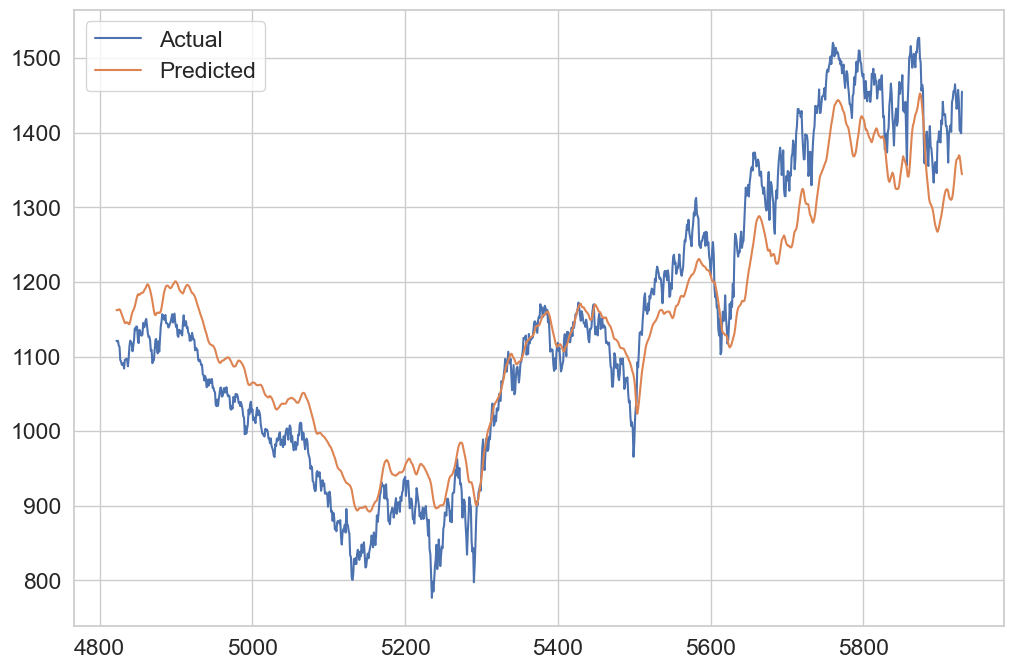

In [279]:

df_final.rename(columns={'Close' : 'Actual', 'Close_Pred': 'Predicted'}, inplace = True)
df_final[['Actual', 'Predicted']].plot()